## Applications v02

Update: 

- dt = R0/V0 is updated at each iteration

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        False,
}

PTHS = {
    'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
    'sav_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_TIME_EVOLUTION/03_APPLICATIONS/'
}

### 1) Functions and model

In [3]:
# COLORMAP
colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered')] # first color is black, last is red
cm     = LinearSegmentedColormap.from_list("Custom", colors, N=20)

In [52]:
### RESOLUTION
rs = np.linspace(10, 900000, 90000)
dr = 10 # meters

### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / r) * np.gradient(r * v, dr)

def N(r, M):
    '''Rotational stability frequency'''
    N2 = np.gradient(M ** 2, dr) / (r ** 3)
    return np.sqrt(N2)

def v_k10(v0, t, lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                     # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})    # Inner-core: v0 interpolated on r * e^t
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t)) # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})               # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)              # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})               # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(t) + v0.rad * (np.exp(2 * t) - 1) / 2                                      # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * v0.rad) + np.log(v0.rad) / v0.rad + t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + t / v0.rad                                                     # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)      # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def compute_RV_plus(r, V, fcor, n=5):
    # Compute R+
    rm       = r[np.nanargmax(V)]
    out      = r > rm          # To find outer-core
    r        = r[out]
    V        = V[out]
    vrt      = vorticity(r, V) # Relative vorticity
    vrt_plan = fcor            # Planetary vorticity

    try: 
        R_plus = r[abs(vrt - n * vrt_plan) < 1e-6][0] # R+
        V_plus = V[r >= R_plus][0]
    except IndexError:
        print('Error: R+ non defined.')
        R_plus = V_plus = np.nan
    
    return R_plus, V_plus

##############################
### SMOOTHING WITH HOLLAND ###
##############################

def get_valid_radii(r, V):
    '''Given the wind profile V, returns the largest radius (and asociated V) on which the profile can be fitted. 
    Indeed, sometimes V isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(r)
    
    ### Lower bound
    # We change it if V[0] = nan
    if np.isnan(V[0]):
        first_valid_index = np.min(np.where(np.isfinite(V)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.count_nonzero(np.isnan(V[first_valid_index:])) > 0:
        last_valid_index  = np.min(np.where(np.isnan(V[first_valid_index:]))[0])# returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
        
    # Define r and spdm
    r = r[first_valid_index:last_valid_index]
    V = V[first_valid_index:last_valid_index]
    
    return r, V

def holland_profile2(r, fcor, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    rho    = 1.15

    r      = r.astype(float) + 0.001 # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt(((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def fit_holland2(r, spdm, fcor, B, Vmin, Rmax, Vmax):
    '''Fit the Holland profile given initial values of lat, pn, pc, Vmin, Rmax and Vmax.
    Returns the optimal parameters found with curve_fit()'''
    # Define the bounds
    BOUNDS = {
        'B':    [1, 3],
        'Vmin': [0, 50],
        'Rmax': [5 * 1000, 500 * 1000],
        'Vmax': [10, 100]
        } 
    # Don't take std into account
    sigma = None
    # Fit
    popt, pcov = curve_fit(
        lambda r, B, Vmin, Rmax, Vmax: holland_profile2(r, fcor, B, Vmin, Rmax, Vmax), 
        r, 
        spdm, 
        p0=[B, Vmin, Rmax, Vmax], 
        bounds=(tuple([BOUNDS[e][0] for e in BOUNDS.keys()]), # NB: lat is fixed
                tuple([BOUNDS[e][1] for e in BOUNDS.keys()])
               ) 
    ) 
    return popt, pcov

def smooth_with_holland(r, V, fcor):
    # Initialize Holland
    B_guess = 1.8
    vmx     = np.nanmax(V)
    rmx     = r[np.nanargmax(V)]
    vmn     = np.nanmin(V)
    
    # Get valid domain
    r_crop, V_crop = get_valid_radii(r, V)
    
    # Fit Holland
    popt, _ = fit_holland2(r_crop, V_crop, fcor, B_guess, vmn, rmx, vmx)
    V_fit   = holland_profile2(r, fcor, popt[0], popt[1], popt[2], popt[3])
    
    return V_fit

################
### FRICTION ###
################

def compute_lbda(r, V, fcor, R_plus, V_plus, gamma=1/40, Cd_plus=2e-3, K=10):
    M_abs = r * V + 0.5 * fcor * (r ** 2)
    M_rel = r * V
        
    left  = gamma * float(Cd_plus * (V_plus ** 2) * R_plus) / (fcor * M_abs)
    right = np.sqrt(N(r, M_abs) / (2 * K))
    lbda  = left * right
    
    return np.array(lbda)

###################
### CHARAC TIME ###
###################

def compute_tau_recirculation(r, V, fcor):
    vmx = np.nanmax(V)
    rmx = r[np.nanargmax(V)]
    r0  = np.sqrt(2 * vmx / (fcor * rmx)) * rmx
    v0  = V[r >= r0][0]
    return (r0 / v0) / 3600

#############
### MODEL ###
#############

def MODEL(r, V_ini, fcor_ini, fcor_fin, HPRMS):
    # Initialize
    vk10s = []
    dts   = []
    
    # Initialization (a parametric profile, e.g Holland)
    V       = V_ini
    delta_m = 0
    tau2    = 999
    
    # Iterations
    while delta_m < HPRMS['delta_h'] + (tau2 / 2.):
        # Append
        vk10s.append(V)
        dts.append(delta_m)
        
        # Compute Coriolis
        fcor           = fcor_ini + (delta_m / HPRMS['delta_h']) * (fcor_fin - fcor_ini)
        
        # Compute dt
        tau1           = (1 / fcor) / 3600
        tau2           = compute_tau_recirculation(r, V, fcor) # Compute R0/V0
        # tau2           = compute_tau_recirculation(r, V, fcor) / 1.3 # Compute R0/V0
        delta_m       += tau2
        dt             = tau2 / tau1
        # print(dt)
        
        # Characteristic scales
        R_plus, V_plus = compute_RV_plus(r, V, fcor, PRMS['n'])
        L              = R_plus
        
        # Compute lambda USING a Holland parametric profile (else noise appears during computation and is amplified in the iterations)
        V_hol = smooth_with_holland(r, V, fcor)
        lbda  = compute_lbda(r, V_hol, fcor, R_plus, V_plus, HPRMS['gamma'], HPRMS['Cd_plus'], HPRMS['K']) # non-dimensional
        
        # Normalize
        V_nrm = xr.DataArray(
            data=V / (fcor * L),
            coords={'rad': r / L}
        )

        # Apply KK10
        V = v_k10(V_nrm, t=dt, lbda=lbda) * fcor * L # dimensional
        
    return vk10s, dts   

def interpolate_two_profiles(r, V_ini, fcor_ini, V_fin, fcor_fin, delta_h, K=20):
    # Hyperparameters
    HPRMS = {
        'delta_h': delta_h,
        'gamma':   1/40,
        'K':       K,              # m^2/s, diffusivity coefficient
        'Cd_plus': 2.5e-3,         # [], drag coefficient, maximal at R+ (so shouldn't be tuned)
    }
    
    # Run model
    vk10s = MODEL(r, V_ini, fcor_ini, fcor_fin, HPRMS)
    
    return vk10s

### OPTIMIZE K ON FINAL VMAX
def binary_search(r, V_ini, fcor_ini, V_fin, fcor_fin, delta_h, K_low=0, K_hgh=100):
    err    = 999
    last_K = 999
    
    # Accepted error on Vmax is 1 m/s
    while abs(err) > 1:
        K_mid = (K_hgh + K_low) // 2
        # print(K_mid)
        
        # Raise Error if K_mid = 0
        if K_mid == 0:
            raise KfitError

        # Compute model and error
        vk10s, _ = interpolate_two_profiles(r, V_ini, fcor_ini, V_fin, fcor_fin, delta_h, K_mid)
        err      = np.nanmax(vk10s[-1]) - np.nanmax(V_fin)

        if err > 0:
            K_hgh = K_mid - 1
        else:
            K_low = K_mid + 1
        
        if K_mid == last_K:
            err = 0
        last_K = K_mid
            
    return K_mid

### K fit exception
class KfitError(Exception):
    "Raised when Kfit = 0 in the binary search"
    pass

### 2) Marie 2020

<xarray.DataArray 'B_hol' (time: 5)>
array([1.79940384, 2.37396689, 1.67238905, 1.78461914, 1.59906357])
Coordinates:
  * time     (time) datetime64[ns] 2020-10-02T02:23:31 ... 2020-10-04T14:29:05


Text(0.5, 1.0, 'MARIE, EP182020')

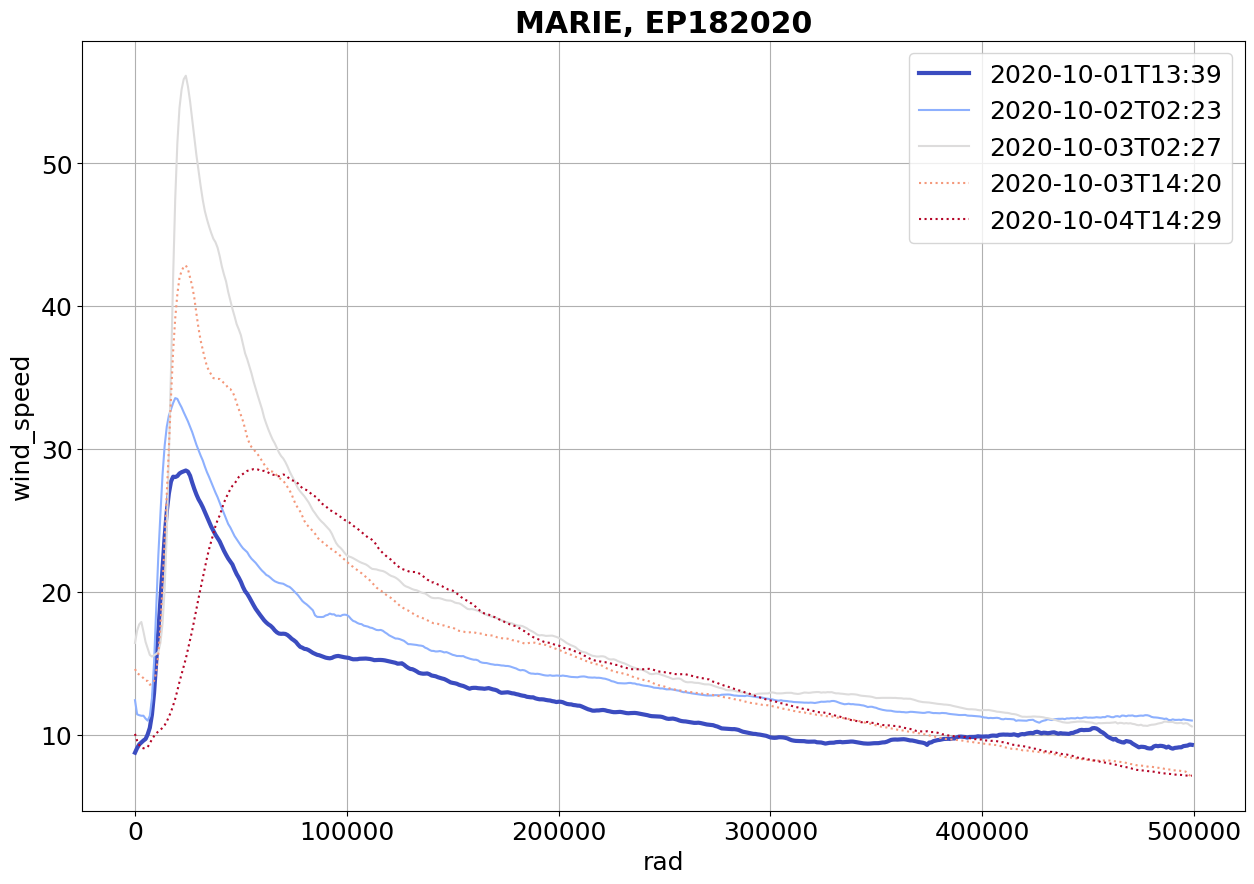

In [46]:
### OPEN DATA
dsg = xr.open_dataset(PTHS['ds_glob_path'])
print(dsg.where(dsg.storm_name == 'MARIE', drop=True).B_hol)

### MARIE
p1    = 'rs2--owi-ca-20201001t133839-20201001t133955-00003-3268A_sw_ep182020_cyclone.nc'
p2    = 'rs2--owi-ca-20201002t022254-20201002t022409-00003-3268A_sw_ep182020_cyclone.nc'
p3    = 's1a-ew-owi-ca-20201003t022600-20201003t022817-000003-04082E_sw_ep182020_cyclone.nc'
p4    = 'rs2--owi-ca-20201003t141913-20201003t142136-00003-3268A_sw_ep182020_cyclone.nc'
p5    = 's1b-ew-owi-ca-20201004t142803-20201004t143007-000003-02CF68_sw_ep182020_cyclone.nc'

p1dsg = 'rs2--owi-cm-20201001t133839-20201001t133955-00003-3268A_sw.nc'
p2dsg = 'rs2--owi-cm-20201002t022254-20201002t022409-00003-3268A_sw.nc'
p3dsg = 's1a-ew-owi-cm-20201003t022600-20201003t022817-000003-04082E_sw.nc'
p4dsg = 'rs2--owi-cm-20201003t141913-20201003t142136-00003-3268A_sw.nc'
p5dsg = 's1b-ew-owi-cm-20201004t142803-20201004t143007-000003-02CF68_sw.nc'

colors = mpl.cm.coolwarm(np.linspace(0, 1, 5))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
plt.grid();plt.legend();plt.title('MARIE, EP182020', weight='bold')

In [47]:
# Open SAR and Holland profiles
DSs = dsg.mean(dim='theta', skipna=True)
DS  = {} # Datasets
VHS = {} # Holland profiles
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg]):
    DS[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    VHS[str(k)] = holland_profile(rs, float(abs(DS[str(k)].lat_center)), float(DS[str(k)].pn_hol), float(DS[str(k)].pc_hol), float(DS[str(k)].Vmin_hol), float(DS[str(k)].Rmax_hol), float(DS[str(k)].Vmax_hol))
    
# Initialize Model profiles
VK10S = {} # Analytical profiles
DTS   = {} # Recirculation time (= Model update time)

In [48]:
### SEARCH OPTIMAL SOLUTIONS FOR K
# Parameters
n     = 4 # Nb of examples (Pairs of SAR)
Kfits = []
for i in range(n):
    print('Step {}'.format(i))
    delta_h = float((DS[str(i + 1)].time - DS[str(i)].time) / np.timedelta64(1, 'h'))
    Kfit    = binary_search(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K_low=0, K_hgh=100)
    Kfits.append(Kfit)

Step 0
Step 1
Step 2
Step 3


KfitError: 

In [49]:
Kfits

[5, 20, 6]

In [50]:
# Ks       = [7, 36, 14, 2]
# Kfits    = [8, 37, 14, 2]
# n = 4

# # Test: Stationary solutions
# VSTS     = {}
# KSTS     = [6, 28, 13, 1]

# Iterate
for i in range(n):
    print('Step {}'.format(i))
    delta_h                      = float((DS[str(i + 1)].time - DS[str(i)].time) / np.timedelta64(1, 'h'))
    K                            = Kfits[i]
    VK10S[str(i)], DTS[str(i)]   = interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)
    
    # # Test: Stationary solution
    # VSTS[str(i)], _              = interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), 3 * delta_h, KSTS[i])

Step 0
Step 1
Step 2
Step 3


IndexError: list index out of range

IndexError: list index out of range

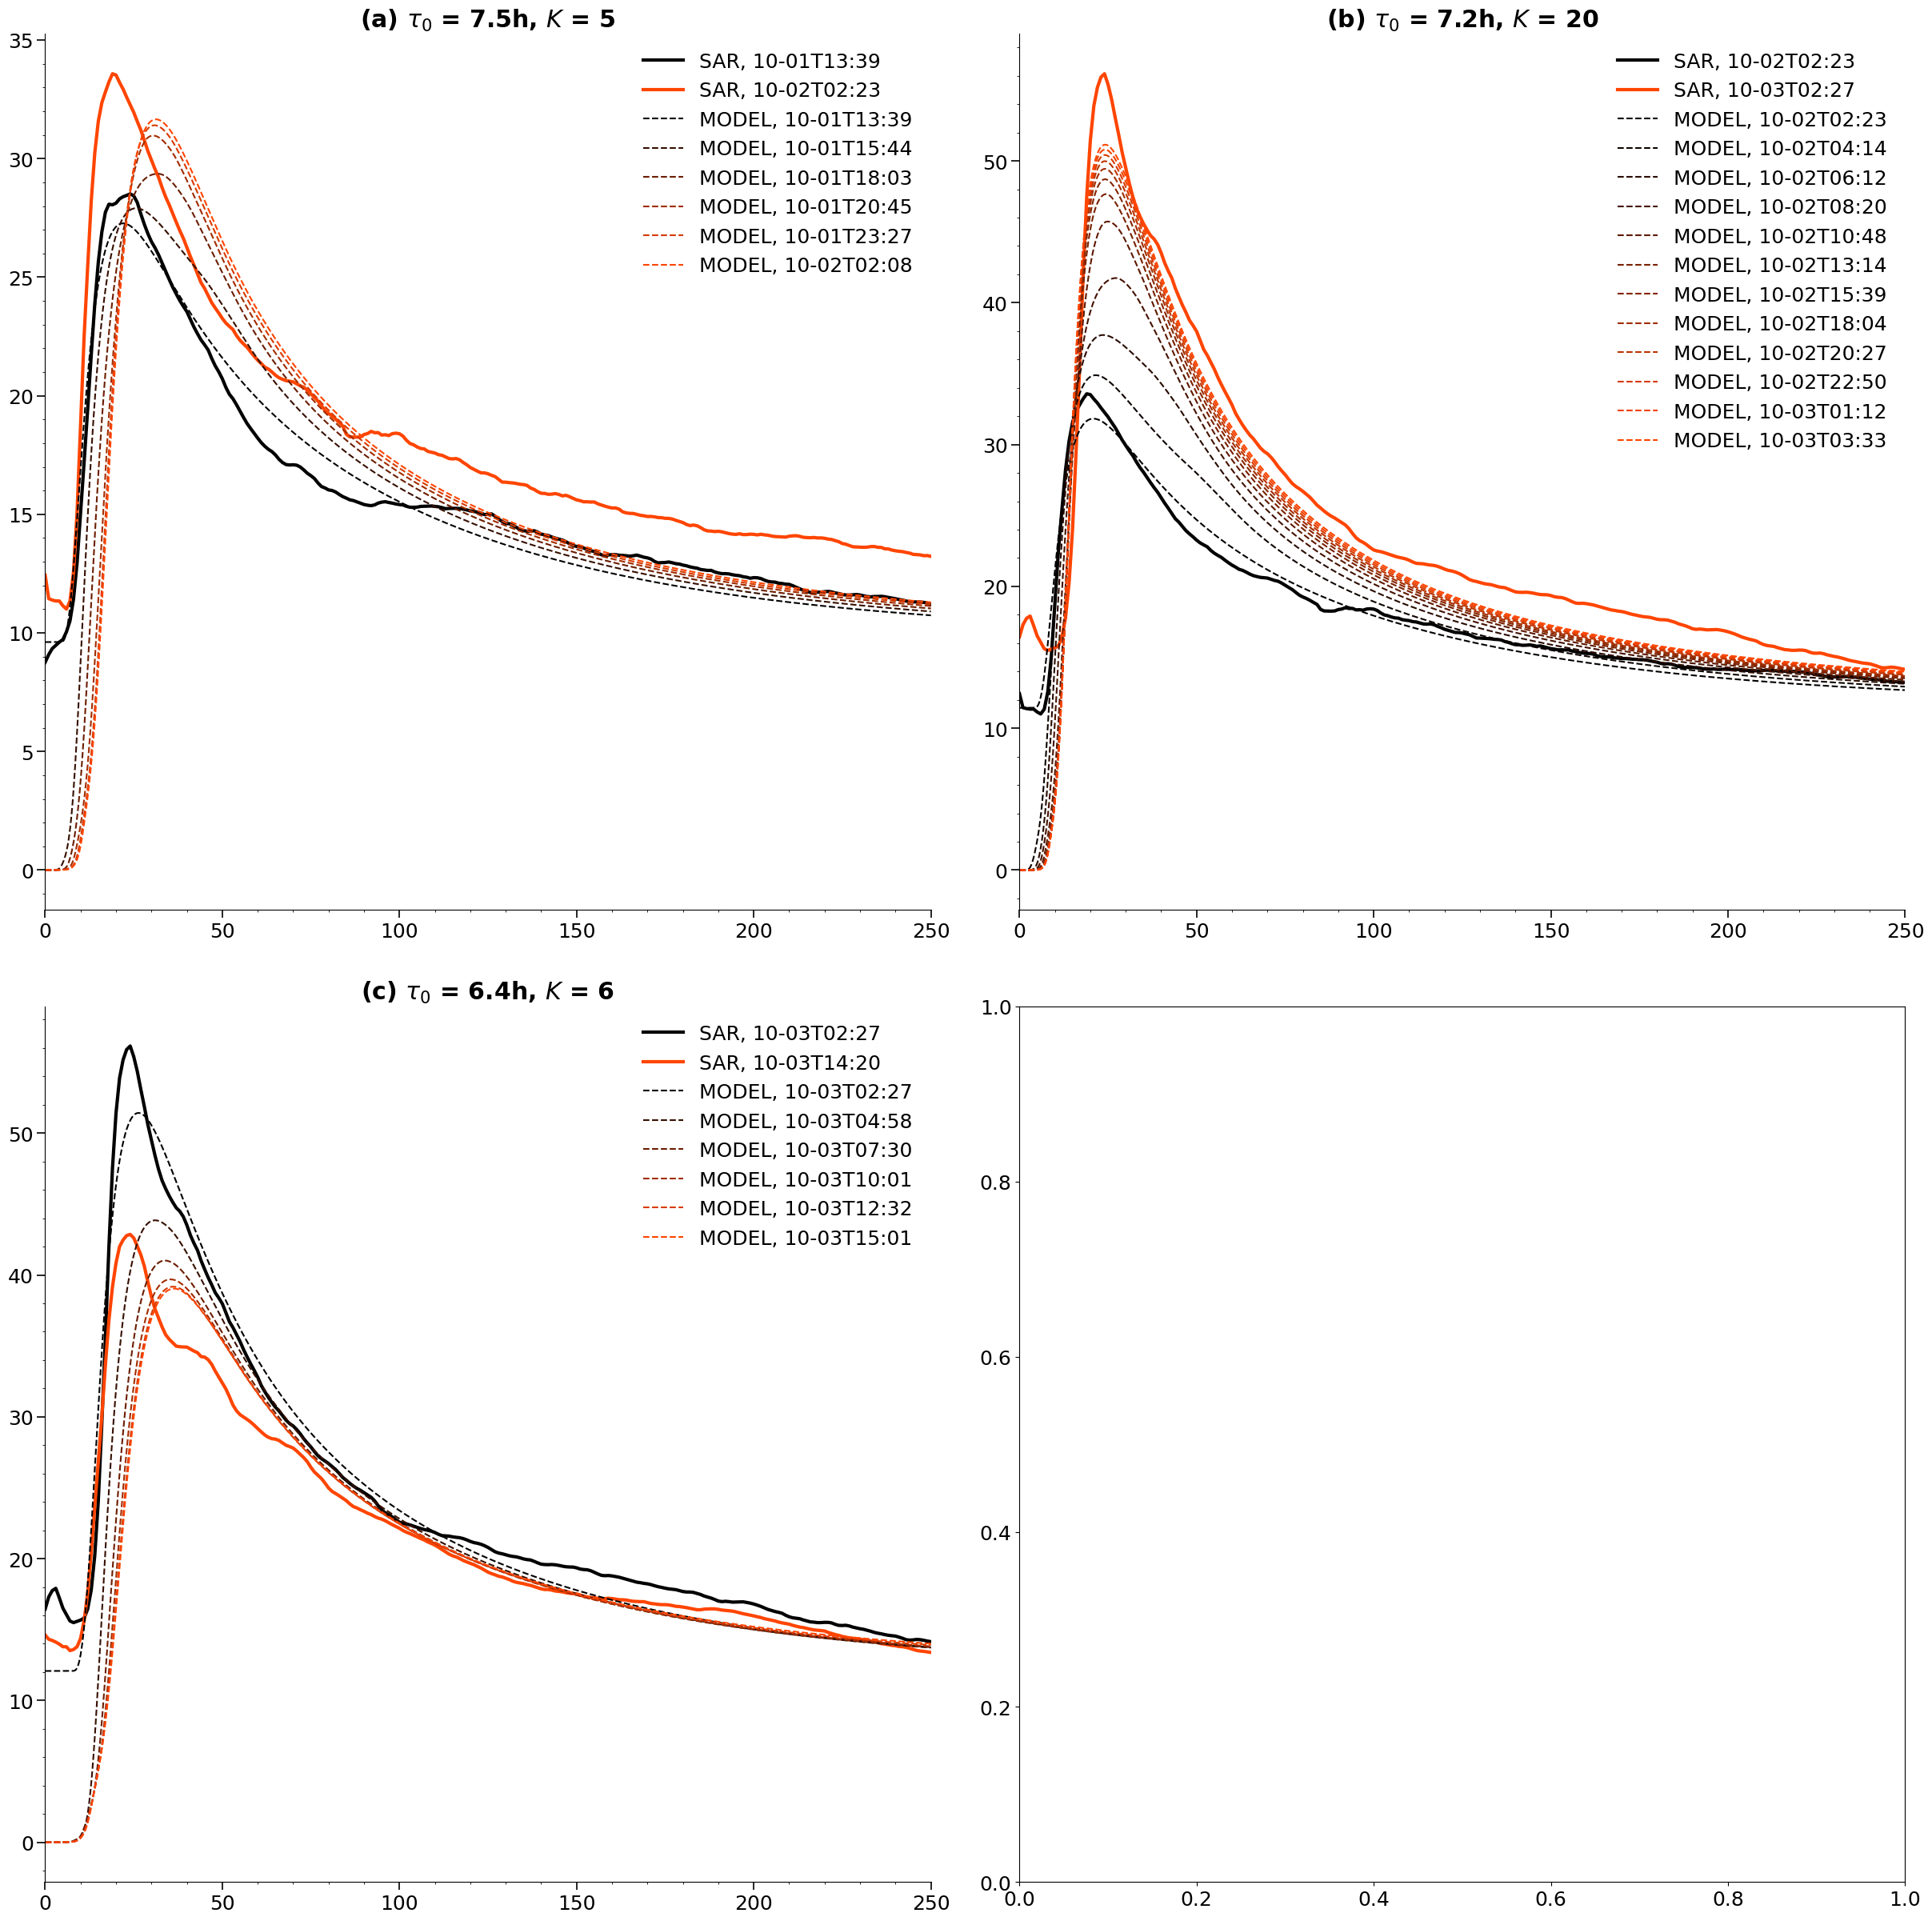

In [51]:
fig      = plt.figure(figsize=(30, 30))
gs       = GridSpec(2, 2, hspace=0.11, wspace=0.1)
grds     = {
    '0': (0, 0),
    '1': (0, 1),
    '2': (1, 0),
    '3': (1, 1)
}
letters  = ['(a)', '(b)', '(c)', '(d)']

axs = []
for i in range(n):
    ax = fig.add_subplot(gs[grds[str(i)]])
    axs.append(ax)
    ax.set_title(r'{} $\tau_0$ = {:.1f}h, $K$ = {}'.format(letters[i], (1 / abs(coriolis(DS[str(i)].lat_center))) / 3600, Kfits[i]), weight='bold')
    # ax.set_title(r'{} $K$ = {}'.format(letters[i], Kfits[i]), weight='bold')
    
    
    # SAR
    ax.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
    ax.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 1)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))
    
    # K10
    l    = len(VK10S[str(i)])
    clrs = cm(np.linspace(0, 1, l))
    for k in range(l):
        ax.plot(rs / 1000, VK10S[str(i)][k], c=clrs[k], linestyle='dashed', label='MODEL, {}'.format(np.datetime_as_string(DS[str(i)].time + np.timedelta64(int(DTS[str(i)][k] * 3600),'s'), unit='m')[5:]))
        
    # # Test: Stationary solution
    # ax.plot(rs / 1000, VSTS[str(i)][-1], c='tab:blue', linestyle='dashed', label='MODEL STEADY', linewidth=2)
        
    # Common grid, Limits
    ax.set_xlim(0, 250)
    ax.minorticks_on();ax.tick_params(length=7, width=1.2)
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend(frameon=False)
    
# Axes labels
axs[0].set_ylabel(r'Wind speed (m/s)');axs[2].set_ylabel(r'Wind speed (m/s)')
axs[2].set_xlabel('Distance from TC center (km)');axs[3].set_xlabel('Distance from TC center (km)')

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'Marie_2020.pdf', bbox_inches='tight', format='pdf')

### 3) Hector 2018

Text(0.5, 1.0, 'HECTOR, EP102018')

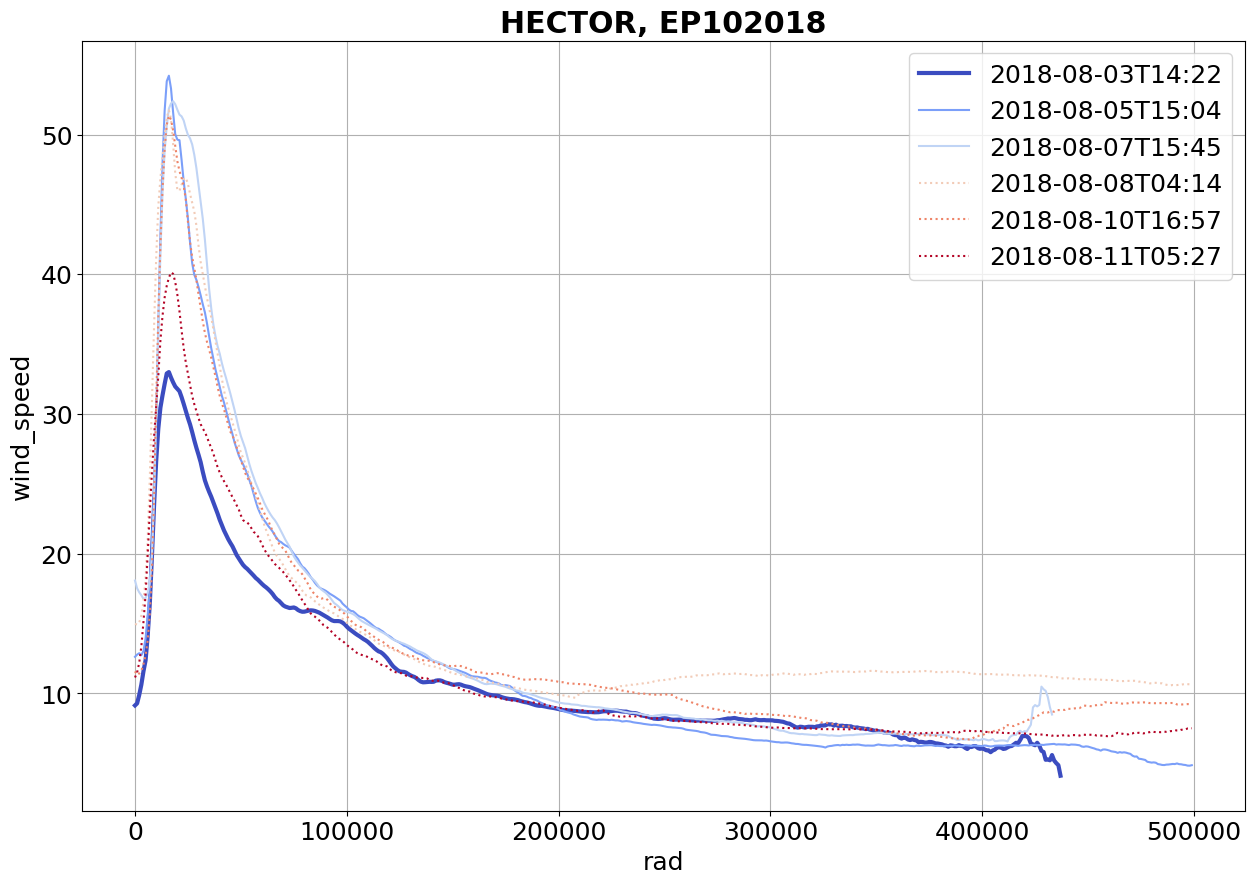

In [40]:
# dsg.where(dsg.storm_name == 'HECTOR', drop=True).sat_file.sortby('time')
# dsg.where(dsg.storm_name == 'HECTOR', drop=True).B_hol

### HECTOR
p1    = 'rs2--owi-ca-20180803t142144-20180803t142259-00003-0444B_sw_ep102018_cyclone.nc'
p2    = 'rs2--owi-ca-20180805t150354-20180805t150510-00003-05A2E_sw_ep102018_cyclone.nc'
p3    = 'rs2--owi-ca-20180807t154512-20180807t154628-00003-07134_sw_ep102018_cyclone.nc'
p4    = 's1a-ew-owi-ca-20180808t041303-20180808t041507-000003-0283BF_sw_ep102018_cyclone.nc'
p5    = 's1b-ew-owi-ca-20180810t165606-20180810t165822-000003-0167B7_sw_ep102018_cyclone.nc'
p6    = 's1b-ew-owi-ca-20180811t052613-20180811t052854-000003-0167F5_sw_ep102018_cyclone.nc'

p1dsg = 'rs2--owi-cm-20180803t142144-20180803t142259-00003-0444B_sw.nc'
p2dsg = 'rs2--owi-cm-20180805t150354-20180805t150510-00003-05A2E_sw.nc'
p3dsg = 'rs2--owi-cm-20180807t154512-20180807t154628-00003-07134_sw.nc'
p4dsg = 's1a-ew-owi-cm-20180808t041303-20180808t041507-000003-0283BF_sw.nc'
p5dsg = 's1b-ew-owi-cm-20180810t165606-20180810t165822-000003-0167B7_sw.nc'
p6dsg = 's1b-ew-owi-cm-20180811t052613-20180811t052854-000003-0167F5_sw.nc'

colors = mpl.cm.coolwarm(np.linspace(0, 1, 6))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)
ds6 = xr.open_dataset(PTHS['sar_dir'] + p6).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)
ws6 = ds6.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
ws6.plot(label='{}'.format(np.datetime_as_string(ds6.time, unit='m')), c=colors[5], linestyle='dotted')
plt.grid();plt.legend();plt.title('HECTOR, EP102018', weight='bold')

In [41]:
# Open profiles
DSs = dsg.mean(dim='theta', skipna=True)
DS  = {} # Datasets
VHS = {} # Holland profiles
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg, p6dsg]):
    DS[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    VHS[str(k)] = holland_profile(rs, float(abs(DS[str(k)].lat_center)), float(DS[str(k)].pn_hol), float(DS[str(k)].pc_hol), float(DS[str(k)].Vmin_hol), float(DS[str(k)].Rmax_hol), float(DS[str(k)].Vmax_hol))
    
# Initialize Model profiles
VK10S = {} # Analytical profiles
DTS   = {} # Recirculation time (= Model update time)

In [42]:
### SEARCH OPTIMAL SOLUTIONS FOR K
# Parameters
n     = 5 # Nb of examples (Pairs of SAR)
Kfits = []
for i in range(n):
    print('Step {}'.format(i))
    delta_h = float((DS[str(i + 1)].time - DS[str(i)].time) / np.timedelta64(1, 'h'))
    Kfit    = binary_search(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K_low=0, K_hgh=100)
    Kfits.append(Kfit)

Step 0
Step 1
Step 2
Step 3
Step 4


In [43]:
# Parameters
# Ks       = [61, 70, 60, 34, 17]
# Kfits    = [62, 75, 62, 33, 17]

# Iterate
for i in range(n):
    delta_h                      = float((DS[str(i + 1)].time - DS[str(i)].time) / np.timedelta64(1, 'h'))
    K                            = Kfits[i]
    VK10S[str(i)], DTS[str(i)]   = interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

Text(0.5, 0, 'Distance from TC center (km)')

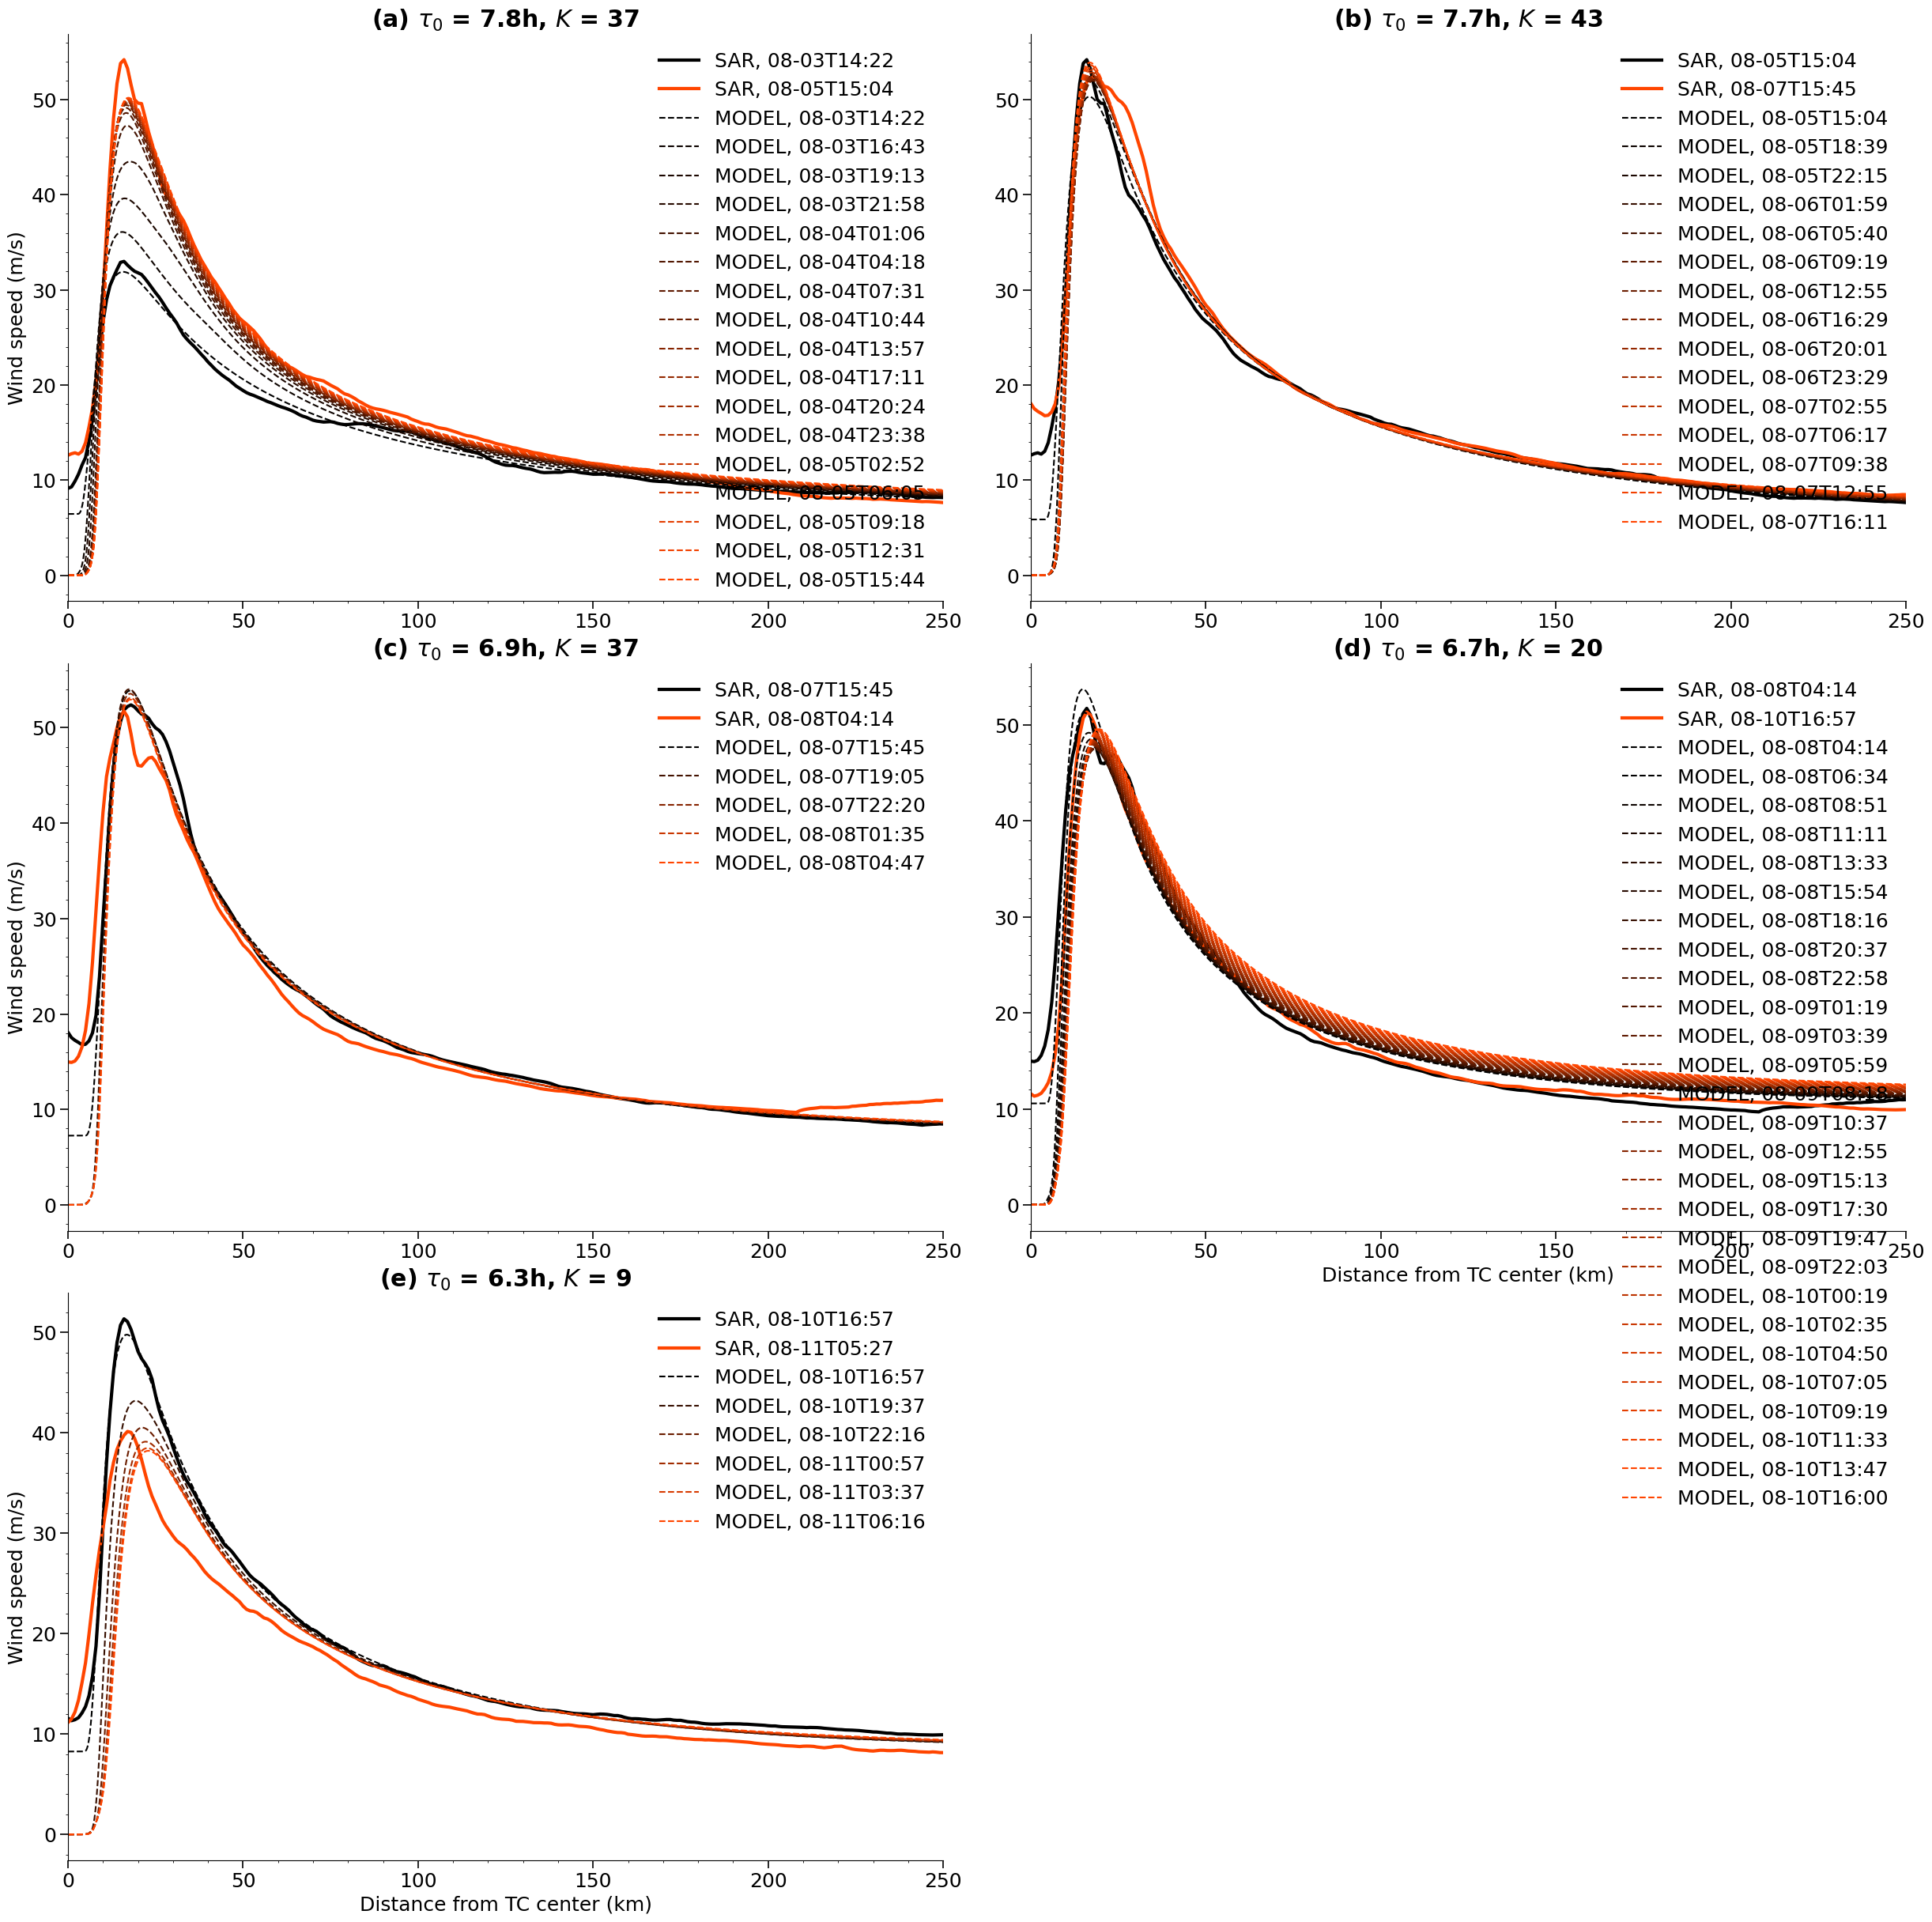

In [44]:
fig      = plt.figure(figsize=(30, 30))
gs       = GridSpec(3, 2, hspace=0.11, wspace=0.1)
grds     = {
    '0': (0, 0),
    '1': (0, 1),
    '2': (1, 0),
    '3': (1, 1),
    '4': (2, 0)
}
letters  = ['(a)', '(b)', '(c)', '(d)', '(e)']

axs = []
for i in range(n):
    ax = fig.add_subplot(gs[grds[str(i)]])
    axs.append(ax)
    ax.set_title(r'{} $\tau_0$ = {:.1f}h, $K$ = {}'.format(letters[i], (1 / abs(coriolis(DS[str(i)].lat_center))) / 3600, Kfits[i]), weight='bold')
    
    # SAR
    ax.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
    ax.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 1)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))
    
    # K10
    l    = len(VK10S[str(i)])
    clrs = cm(np.linspace(0, 1, l))
    # clrs = mpl.cm.copper(np.linspace(0, 1, l))
    for k in range(l):
        ax.plot(rs / 1000, VK10S[str(i)][k], c=clrs[k], linestyle='dashed', label='MODEL, {}'.format(np.datetime_as_string(DS[str(i)].time + np.timedelta64(int(DTS[str(i)][k] * 3600),'s'), unit='m')[5:]))
        
    # Common grid, Limits
    ax.set_xlim(0, 250)
    ax.minorticks_on();ax.tick_params(length=7, width=1.2)
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend(frameon=False, loc='upper right')
    
# Axes labels
axs[0].set_ylabel(r'Wind speed (m/s)');axs[2].set_ylabel(r'Wind speed (m/s)');axs[4].set_ylabel(r'Wind speed (m/s)')
axs[3].set_xlabel('Distance from TC center (km)');axs[4].set_xlabel('Distance from TC center (km)')

### 4) Larry 2021

Text(0.5, 1.0, 'LARRY')

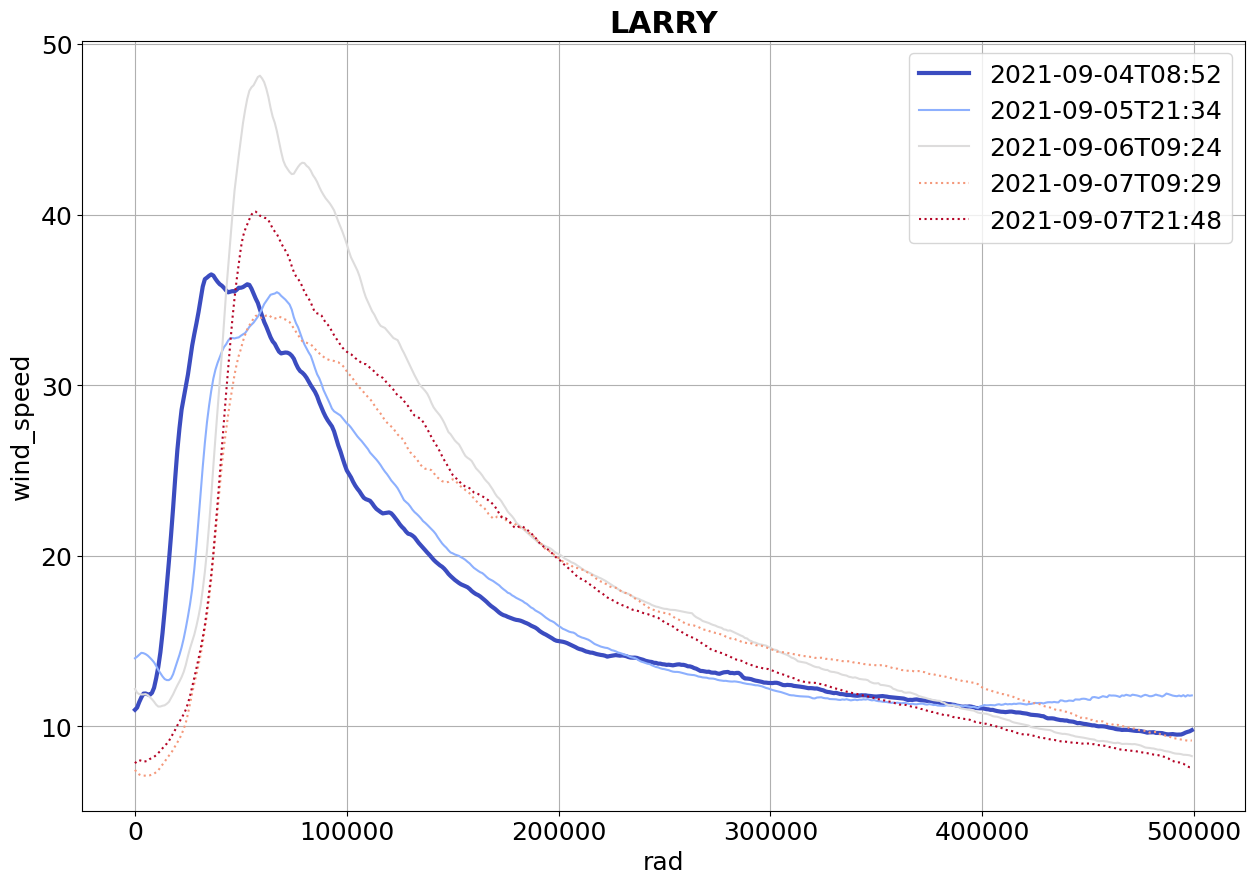

In [34]:
# dsg.where(dsg.storm_name == 'LARRY', drop=True).sat_file.sortby('time')
# dsg.where(dsg.storm_name == 'LARRY', drop=True).B_hol

### LARRY
p1    = 's1b-ew-owi-ca-20210904t085102-20210904t085352-000003-036818_sw_al122021_cyclone.nc'
p2    = 'rs2--owi-ca-20210905t213342-20210905t213606-00003-1E37F_sw_al122021_cyclone.nc'
p3    = 's1a-ew-owi-ca-20210906t092329-20210906t092604-000003-04ACFC_sw_al122021_cyclone.nc'
p4    = 'rs2--owi-ca-20210907t092755-20210907t093019-00003-1F5B6_sw_al122021_cyclone.nc'
p5    = 's1b-ew-owi-ca-20210907t214630-20210907t215005-000003-0369AB_sw_al122021_cyclone.nc'

p1dsg = 's1b-ew-owi-cm-20210904t085102-20210904t085352-000003-036818_sw.nc'
p2dsg = 'rs2--owi-cm-20210905t213342-20210905t213606-00003-1E37F_sw.nc'
p3dsg = 's1a-ew-owi-cm-20210906t092329-20210906t092604-000003-04ACFC_sw.nc'
p4dsg = 'rs2--owi-cm-20210907t092755-20210907t093019-00003-1F5B6_sw.nc'
p5dsg = 's1b-ew-owi-cm-20210907t214630-20210907t215005-000003-0369AB_sw.nc'

colors = mpl.cm.coolwarm(np.linspace(0, 1, 5))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
plt.grid();plt.legend();plt.title('LARRY', weight='bold')

In [35]:
# Open profiles
DSs = dsg.mean(dim='theta', skipna=True)
DS  = {} # Datasets
VHS = {} # Holland profiles
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg]):
    DS[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    VHS[str(k)] = holland_profile(rs, float(abs(DS[str(k)].lat_center)), float(DS[str(k)].pn_hol), float(DS[str(k)].pc_hol), float(DS[str(k)].Vmin_hol), float(DS[str(k)].Rmax_hol), float(DS[str(k)].Vmax_hol))
    
# Initialize Model profiles
VK10S = {} # Analytical profiles
TAU2S = {} # Recirculation time (= Model update time)

In [36]:
### SEARCH OPTIMAL SOLUTIONS FOR K
# Parameters
n     = 4 # Nb of examples (Pairs of SAR)
Kfits = []
for i in range(n):
    print('Step {}'.format(i))
    delta_h = float((DS[str(i + 1)].time - DS[str(i)].time) / np.timedelta64(1, 'h'))
    Kfit    = binary_search(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K_low=0, K_hgh=100)
    Kfits.append(Kfit)

Step 0
Step 1
Step 2
Step 3


In [37]:
# Parameters
# Ks       = [4, 20, 3, 5]
# Kfits    = [4, 20, 3, 5]

# Iterate
for i in range(n):
    delta_h                      = float((DS[str(i + 1)].time - DS[str(i)].time) / np.timedelta64(1, 'h'))
    K                            = Kfits[i]
    VK10S[str(i)], DTS[str(i)]   = interpolate_two_profiles(rs, VHS[str(i)], float(abs(coriolis(DS[str(i)].lat_center))), VHS[str(i + 1)], float(abs(coriolis(DS[str(i + 1)].lat_center))), delta_h, K)

Text(0.5, 0, 'Distance from TC center (km)')

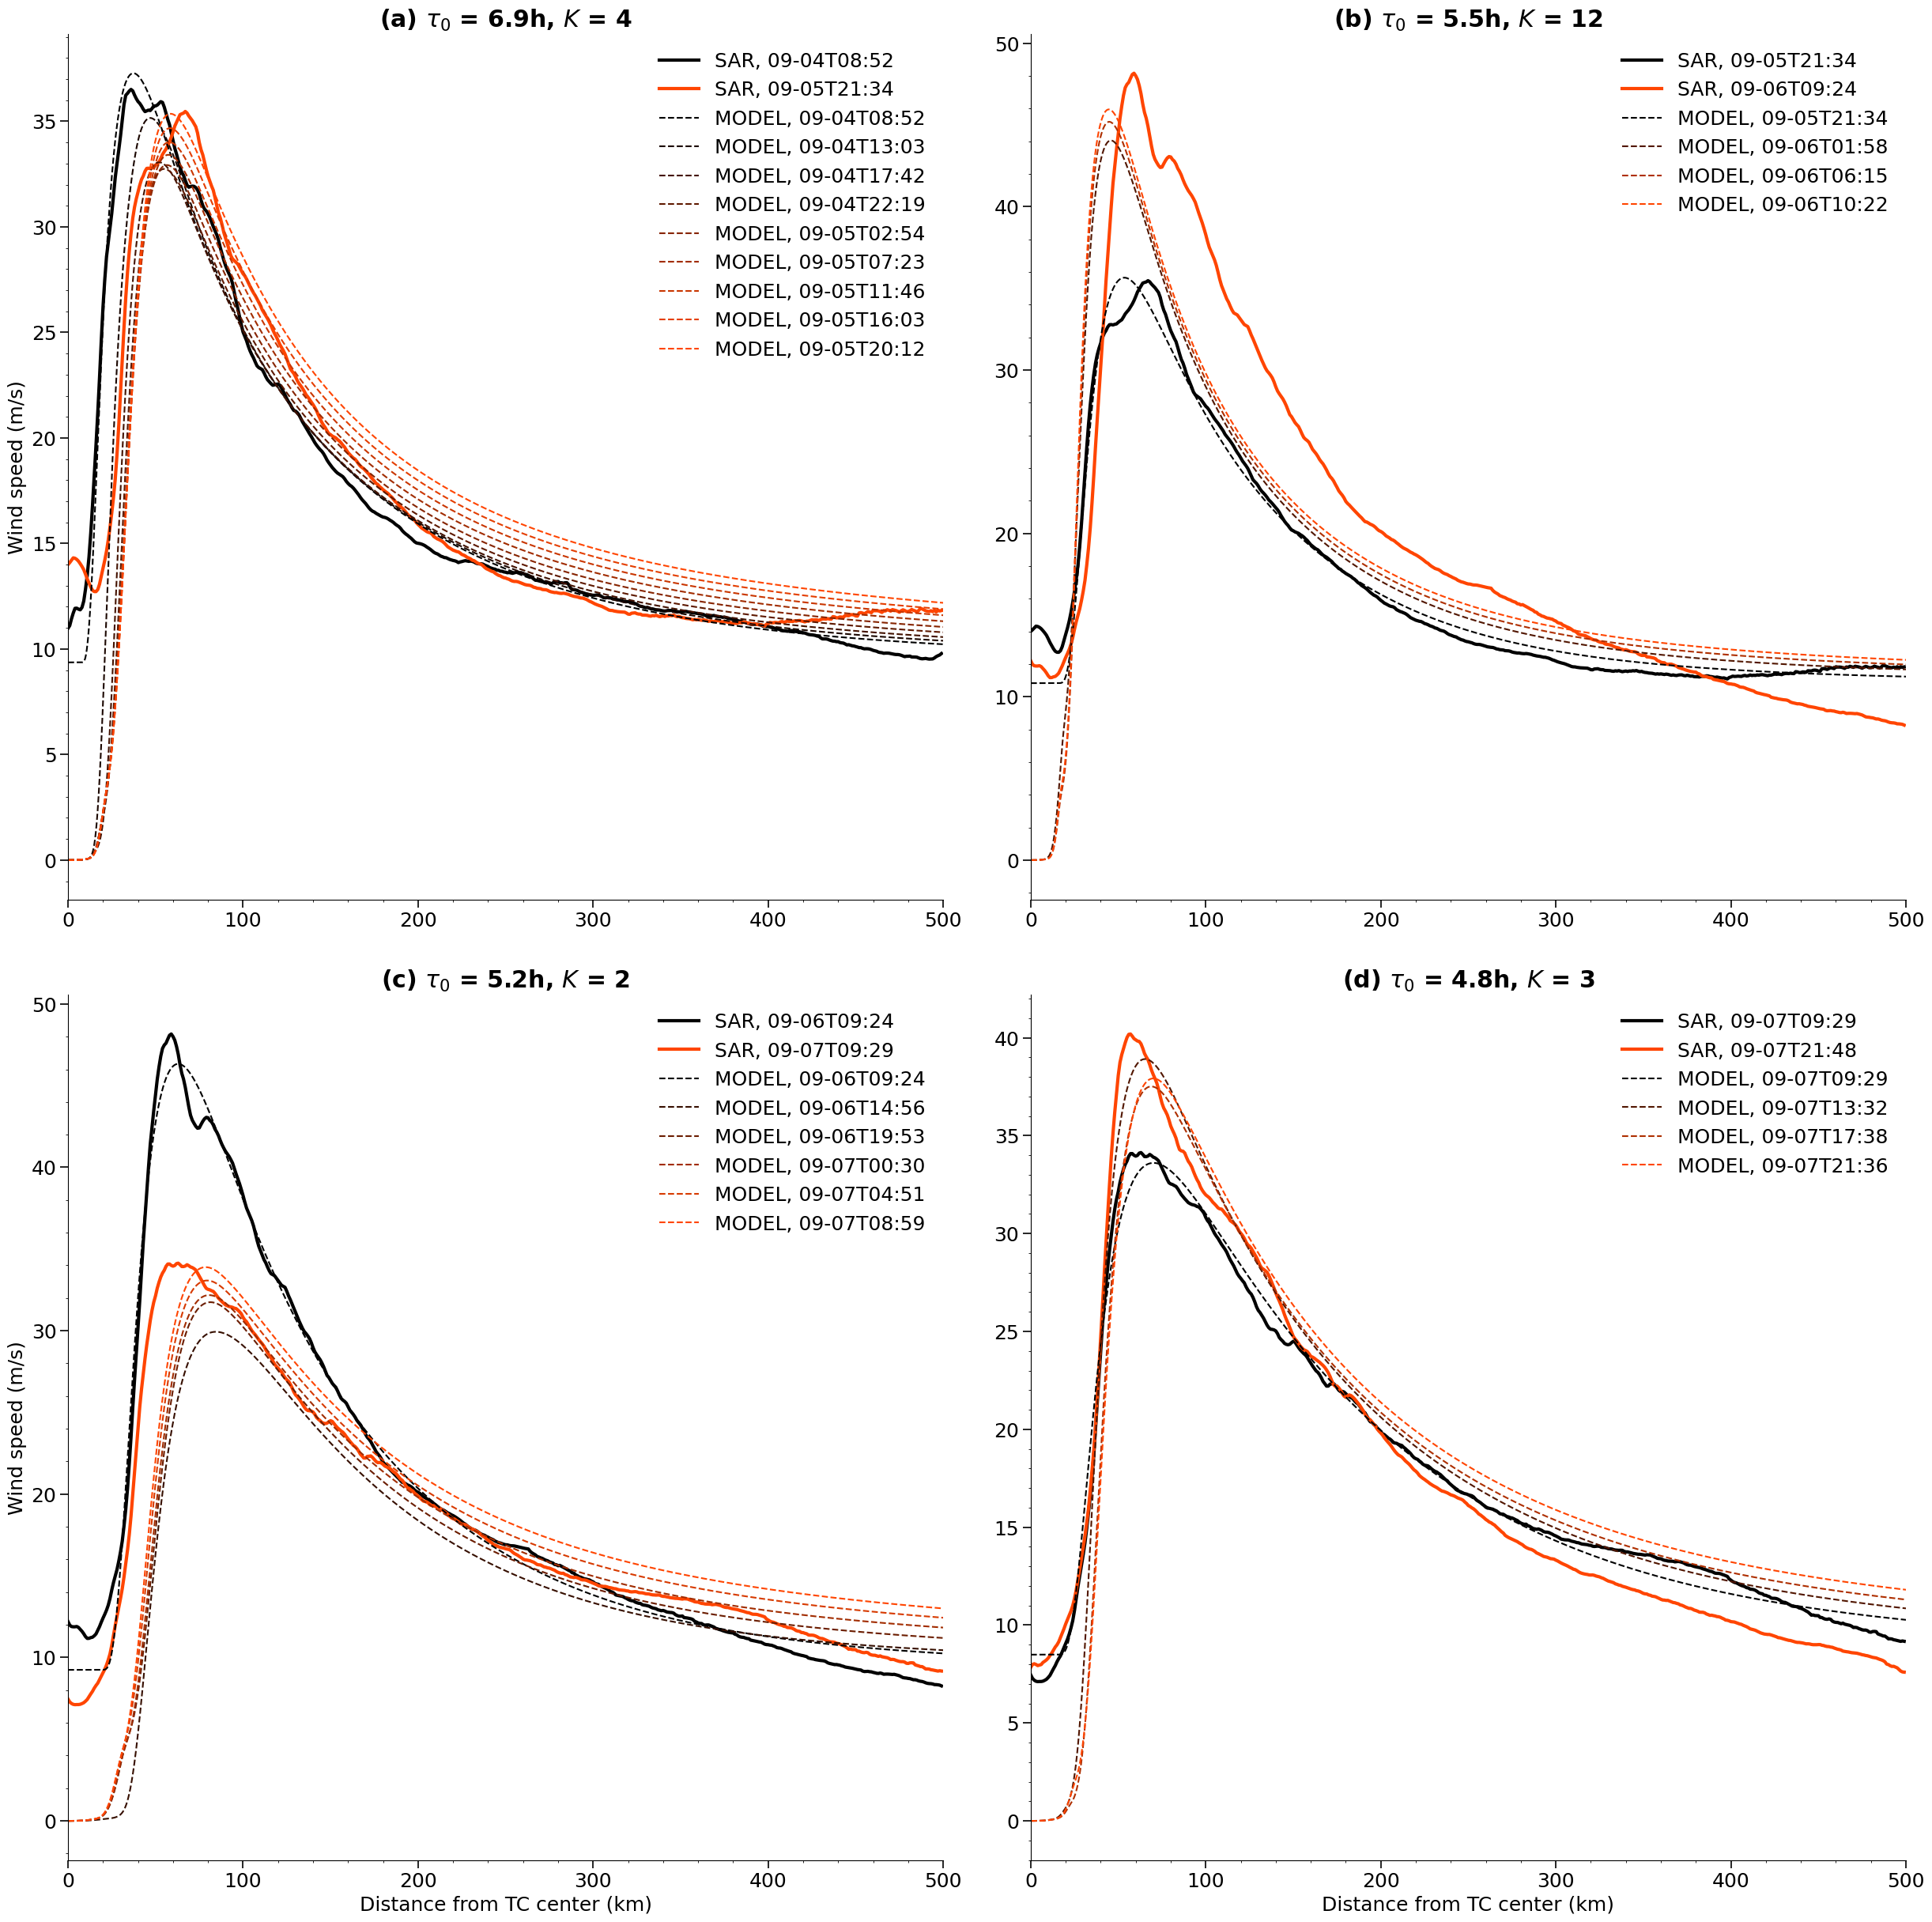

In [38]:
fig      = plt.figure(figsize=(30, 30))
gs       = GridSpec(2, 2, hspace=0.11, wspace=0.1)
grds     = {
    '0': (0, 0),
    '1': (0, 1),
    '2': (1, 0),
    '3': (1, 1),
}
letters  = ['(a)', '(b)', '(c)', '(d)']

axs = []
for i in range(n):
    ax = fig.add_subplot(gs[grds[str(i)]])
    axs.append(ax)
    ax.set_title(r'{} $\tau_0$ = {:.1f}h, $K$ = {}'.format(letters[i], (1 / abs(coriolis(DS[str(i)].lat_center))) / 3600, Kfits[i]), weight='bold')
    
    # SAR
    ax.plot(DS[str(i)].rad / 1000, DS[str(i)].wind_speed, c='k', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i)].time, unit='m')[5:]))
    ax.plot(DS[str(i + 1)].rad / 1000, DS[str(i + 1)].wind_speed, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(DS[str(i + 1)].time, unit='m')[5:]))
    
    # K10
    l    = len(VK10S[str(i)])
    clrs = cm(np.linspace(0, 1, l))
    # clrs = mpl.cm.copper(np.linspace(0, 1, l))
    for k in range(l):
        ax.plot(rs / 1000, VK10S[str(i)][k], c=clrs[k], linestyle='dashed', label='MODEL, {}'.format(np.datetime_as_string(DS[str(i)].time + np.timedelta64(int(DTS[str(i)][k] * 3600),'s'), unit='m')[5:]))
        
    # Common grid, Limits
    ax.set_xlim(0, 500)
    ax.minorticks_on();ax.tick_params(length=7, width=1.2)
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend(frameon=False, loc='upper right')
    
# Axes labels
axs[0].set_ylabel(r'Wind speed (m/s)');axs[2].set_ylabel(r'Wind speed (m/s)')
axs[2].set_xlabel('Distance from TC center (km)');axs[3].set_xlabel('Distance from TC center (km)')